In [1]:
# dataloader code
from unet import *
from segmentation_dataset import SegmentationDataset

import matplotlib.pyplot as plt
import numpy as np
import torch
import os
from loguru import logger

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm, trange

def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

train_path = "small_dataset/images/nir/"
val_path = "small_dataset/images/nir/"
test_path = "small_dataset/images/nir/"

train_labels_path = "small_dataset/labels/"
val_labels_path = "small_dataset/labels/"
test_labels_path = "small_dataset/labels/"

train_img_names_index = os.listdir(train_path)[:10]
val_img_names_index = os.listdir(val_path)[:10]
test_img_names_index = os.listdir(test_path)[:10]

labels_one_hot = {}
k = 8
i=0
for label in listdir_nohidden(train_labels_path):
    if label!="storm_damage":
        labels_one_hot[label] = np.zeros((k,))
        labels_one_hot[label][i] = 1
        i+=1

train_dataset = SegmentationDataset(train_img_names_index, labels_one_hot, train_path, train_labels_path, use_cache=True)
val_dataset = SegmentationDataset(val_img_names_index, labels_one_hot, val_path, val_labels_path, use_cache=True)
test_dataset = SegmentationDataset(test_img_names_index, labels_one_hot, test_path, test_labels_path, use_cache=True)

In [2]:
# SETTINGS
Use_GPU = True
Lr = 1e-3
channels = 1  # NIR vs RGB
classes = 9  # outputs (9 labels + 1 background)
maxEpochs = 10
batch_size = 5
shuffle = True

# Code 
if Use_GPU: 
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print('cuda used')
    else:
        device = torch.device('cpu')
else:
    device = torch.device('cpu')
# initalize model 

# fix activationfunc, dropout and other settings for model as parameters later 

model = UNet(channels, classes).to(device)

trainValRate = 0.7  # not in use
lrRatesplan = None  # not in use
activation = "relu"  # not in use 
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.SGD(model.parameters(), Lr)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

cuda used


In [3]:
trainingAcc = []
trainingLoss = []
validationAcc = []
validationLoss = []

def itterProgress(x, text = "training"):
    return tqdm(enumerate(x), text, total = len(x))

def run(): 
    # itter = itterProgress(trainX)

    for epoch in range(maxEpochs):
        train(epoch)

    torch.save(model.state_dict(), "trained_model.pth")
    

def train(epoch):
    model.train()
    for i, (batch_x, batch_y) in enumerate(train_dataloader):
        indata, target = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        indata = indata.unsqueeze(1)
        out = model(indata)
        out_softmax = torch.softmax(out, 1)
        img = postprocess(out_softmax)
        
        train_acc = iou(img, target)
        loss = criterion(out, target)
        train_loss = loss.item()
        
        trainingAcc.append(train_acc)
        trainingLoss.append(train_loss)

        loss.backward()
        optimizer.step()

        val_acc, val_loss = validate()

        validationAcc.append(val_acc)
        validationLoss.append(val_loss)

        logger.info(f"Epoch {epoch} batch {i+1}/{len(train_dataloader)} loss={train_loss} acc={train_acc} val_loss={val_loss} val_acc={val_acc}")

        if val_loss > np.mean(validationLoss):
            print("Overfitting detected")
            break

def validate():
    model.eval()
    validationAcc_temp = []
    validationLoss_temp = []
    for i, (batch_x, batch_y) in enumerate(val_dataloader):
        indata, target = batch_x.to(device), batch_y.to(device)
        
        with torch.no_grad():
            indata = indata.unsqueeze(1)
            out = model.forward(indata)
            out_softmax = torch.softmax(out, 1)
            img = postprocess(out_softmax)
            
            val_acc = iou(img, target)            
            loss = criterion(out, target)
            val_loss = loss.item()

            validationAcc_temp.append(val_acc)
            validationLoss_temp.append(val_loss)
    
    return np.mean(validationAcc_temp),np.mean(validationLoss_temp)

def postprocess(img):
    img = torch.argmax(img, dim=1)
    img = img.cpu().numpy()
    img = np.squeeze(img)
    img = torch.from_numpy(img).type(torch.int64)
    img = img.to(device)
    # img = re_normalize(img)
    return img

def iou(prediction, target):
    eps = 0
    score = 0

    for k in range(1, 10):
        intersection = torch.sum((prediction==target) * (target==k)).item()
        union = torch.sum(prediction==k).item() + torch.sum(target==k).item()
        iou_k = 0 if intersection == 0 else (intersection + eps) / (union + eps)
        score += iou_k

    score = score / 9
    return score

In [4]:
run()

2021-05-22 18:36:56.384 | INFO     | __main__:train:43 - Epoch 0 batch 1/2 loss=2.3993475437164307 acc=0.0 val_loss=1.5596140623092651 val_acc=0.007518002053739755
2021-05-22 18:36:56.936 | INFO     | __main__:train:43 - Epoch 0 batch 2/2 loss=1.558070182800293 acc=0.006600442133687505 val_loss=0.9701902568340302 val_acc=0.010667212302601354
2021-05-22 18:36:57.482 | INFO     | __main__:train:43 - Epoch 1 batch 1/2 loss=1.0045342445373535 acc=0.01107591810525796 val_loss=0.5570974946022034 val_acc=0.010645164249820887
2021-05-22 18:36:58.032 | INFO     | __main__:train:43 - Epoch 1 batch 2/2 loss=0.5244771838188171 acc=0.010236319862488607 val_loss=0.3469485938549042 val_acc=0.010629618285262616
2021-05-22 18:36:58.589 | INFO     | __main__:train:43 - Epoch 2 batch 1/2 loss=0.3274354636669159 acc=0.011051639174259494 val_loss=0.23573695868253708 val_acc=0.010631139109478757
2021-05-22 18:36:59.146 | INFO     | __main__:train:43 - Epoch 2 batch 2/2 loss=0.253653347492218 acc=0.010207148

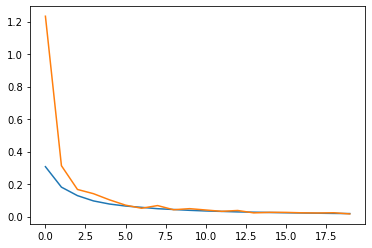

In [12]:
import matplotlib.pyplot as plt
plt.plot(validationLoss,color)
plt.plot(trainingLoss)

In [34]:
batch_x, batch_y = next(iter(train_dataloader))
x = batch_x[0]
y = batch_y[0]

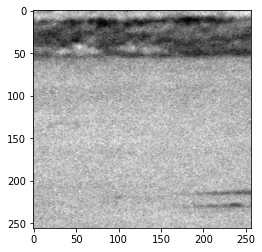

In [35]:
plt.imshow(x,cmap='gray')

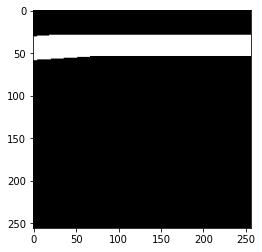

In [36]:
plt.imshow(y, cmap='gray')

In [37]:
batch_x = batch_x.to(device)
indata = batch_x.unsqueeze(1)
out = model(indata)
out_softmax = torch.softmax(out, 1)
img = postprocess(out_softmax)
img

RuntimeError: CUDA out of memory. Tried to allocate 40.00 MiB (GPU 0; 5.80 GiB total capacity; 4.19 GiB already allocated; 43.38 MiB free; 4.25 GiB reserved in total by PyTorch)

In [13]:
# import tensorflow as tf

for i in range(10):
    probs = out[0][i].cpu()
    probs = probs.detach().numpy()
    plt.show()
    plt.imshow(probs, cmap='gray')

NameError: name 'out' is not defined

In [ ]:
from skimage.transform import rescale

x = torch.Tensor([[0, 1, 1, 0], [1, 1, 0, 0], [1, 1, 1, 1], [1, 1, 1, 1]])
print(x)
print(x.shape)

#T = torch.zeros(3, 200, 120)
# print(T.shape)

x = rescale(x, 1/2, order=0, anti_aliasing=False)

print(x.shape)
print(x)
